## Check the q-score calibration from `minimap2` using the 3d7 reference genome
---

In [1]:
import os
import sys
import configparser
import getopt
import numpy as np
import pandas as pd
from collections import Counter

from lib.mutation import *
from lib.error import *
from lib.coi import *

In [2]:
from matplotlib import patches
from matplotlib import lines
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# inline stylization
%matplotlib inline
sns.set_style('white')
sns.set_style('ticks')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.figsize'] = [4, 4]

## 0 Settings

In [3]:
platform = "ont"
country = "zambia"
date = "2019-04-10"
sample = "BC05"
gene = "msp2"

In [4]:
analysis_dir = os.path.join("../analysis", platform, country, date)
results_dir = os.path.join("../results", platform, country, date)
output_dir = os.path.join(analysis_dir, "coi")
figs_dir = os.path.join("../figs", platform, country, date, "coi")

In [5]:
gene_ini = os.path.join("../data/resources/pf-regions/", gene + ".ini")
gene_ini_path = os.path.dirname(gene_ini)

In [6]:
config = configparser.ConfigParser()
config.read(gene_ini)
gene_dt = {}
gene_dt["name"] = config.get("Parameters", "name")
gene_dt["id"] = config.get("Parameters", "id")
gene_dt["genome"] = config.get("Parameters", "genome")
gene_dt["gff"] = config.get("Parameters", "gff")

In [7]:
os.listdir(output_dir)

['BC04.MSP2.gene_array.npy',
 'BC05.MSP2.gene_array.npy',
 'BC06.MSP2.gene_array.npy',
 'BC06.MSP2.phred_array.npy',
 'BC01.MSP2.gene_array.npy',
 'BC01.MSP2.sam',
 'BC03.MSP2.gene_array.npy',
 'BC02.MSP2.gene_array.npy',
 'BC06.MSP2.sam',
 'BC03.MSP2.sam',
 'BC02.MSP2.sam',
 'BC05.MSP2.phred_array.npy',
 'BC04.MSP2.sam',
 'BC05.MSP2.sam']

## 1 Load `gene_array` and `phred_array`

In [8]:
gene_fn = "%s.%s.gene_array.npy" % (sample, gene_dt["name"])
phred_fn = "%s.%s.phred_array.npy" % (sample, gene_dt["name"])

In [9]:
gene_array = np.load(os.path.join(output_dir, gene_fn))
phred_array = np.load(os.path.join(output_dir, phred_fn))

In [10]:
print("Gene array:", gene_array.shape)
print("PHRED array:", phred_array.shape)

Gene array: (43228, 819)
PHRED array: (43228, 819)


In [11]:
prob_array = 10**(phred_array/-10)
prob_array[prob_array > 1.0] = 1.0

In [12]:
prob_array[:10, :10]

array([[1.        , 0.15848932, 0.07943282, 0.03162278, 0.01584893,
        0.02511886, 0.03162278, 0.03981072, 0.03162278, 0.00158489],
       [0.00251189, 0.01995262, 0.06309573, 0.07943282, 1.        ,
        0.05011872, 0.1       , 0.03981072, 0.00501187, 0.00251189],
       [0.31622777, 0.39810717, 0.31622777, 0.39810717, 0.39810717,
        1.        , 1.        , 0.19952623, 0.07943282, 0.02511886],
       [0.01584893, 0.00316228, 0.00398107, 0.00158489, 0.01995262,
        0.00316228, 0.02511886, 0.03981072, 0.01584893, 0.00158489],
       [1.        , 0.15848932, 0.03981072, 0.00501187, 0.03162278,
        0.15848932, 0.12589254, 0.12589254, 0.07943282, 0.19952623],
       [1.        , 0.00501187, 0.00199526, 0.00199526, 0.01      ,
        0.00316228, 0.00630957, 0.03162278, 0.02511886, 0.01584893],
       [0.00158489, 0.02511886, 0.00199526, 0.00158489, 0.00501187,
        0.00398107, 0.01584893, 0.02511886, 0.00398107, 0.01995262],
       [0.25118864, 0.63095734, 0.6309573

## 2 Load reference sequence

In [13]:
gene_bed = "../data/resources/pf-regions/%s.exons.bed" % gene_dt["name"]
gene_fasta = gene_bed.replace(".bed", ".fasta")

In [14]:
reverse = True
with open(gene_fasta, "r+") as fn:
    for l in fn:
        if l[0] != ">":
            if reverse:
                gene_bases = [complement_map[c] for c in l.rstrip()[::-1]]
            else:
                gene_bases = l.rstrip()
            ref = np.array([dna_to_ints[c] for c in gene_bases])

In [15]:
ref[:10]

array([1, 2, 4, 1, 1, 4, 4, 2, 1, 1])

## 3 Compute error frequencies across different q-values

$$ Q_{PHRED} = -10log(p_{error}) $$

In [16]:
error_array = gene_array != ref

In [17]:
dt = {
    "q": [],
    "n_total": [],
    "n_error": [],
}

# COMPUTE STATISTICS FOR EVERY Q VALUE
# Note I am ignoring deletions
qs = np.arange(phred_array.max() + 1)  # arange goes from 0 to n - 1
for q in qs:
    ix = phred_array == q  # entries with a Q-value of `q`
    dt["q"].append(q)
    dt["n_total"].append(ix.sum())  # total entries
    dt["n_error"].append(error_array[ix].sum())  # error entries

In [18]:
df = pd.DataFrame(dt)
df.head()

,q,n_total,n_error
0,0,0,0
1,1,226152,67123
2,2,449958,102718
3,3,683751,125484
4,4,854037,121628


In [19]:
df["p_error"] = df["n_error"]/df["n_total"]
df["p_phred"] = 10**((df["q"]-1)/-10)

### a Q-score distribution

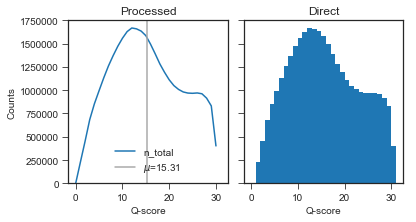

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1)

# plot
ax[0].plot(df["q"], df["n_total"])
mu = phred_array[phred_array >= 0].mean()
ax[0].axvline(mu, color='darkgrey', label="$\mu$=%.02f" % mu)
ax[0].legend()

# labels
ax[0].set_title("Processed")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Q-score")

h = ax[1].hist(phred_array.flatten(), 
               bins=np.arange(phred_array.max() + 2))  # otherwise the last bin has two values

ax[1].set_title("Direct")
ax[1].set_xlabel("Q-score")

# save
fig.savefig(os.path.join(figs_dir, "%s.%s.q_dist.png" % (sample, gene_dt["name"])),
            bbox_inches="tight",
            pad_inches=0.5)

### b Q-score calibration

In [21]:
import statsmodels.formula.api as smf

In [22]:
model = smf.ols("p_error ~ p_phred", df)
result = model.fit()

In [23]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                p_error   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     4966.
Date:                Thu, 08 Aug 2019   Prob (F-statistic):           4.54e-33
Time:                        15:13:20   Log-Likelihood:                 113.53
No. Observations:                  30   AIC:                            -223.1
Df Residuals:                      28   BIC:                            -220.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0028      0.001     -2.271      0.0

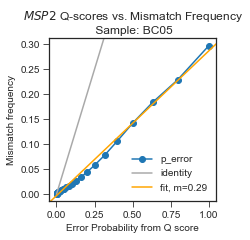

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.plot(df["p_phred"], df["p_error"], 'o-')

# additional
ax.autoscale(False)
ax.plot([0, 1], [0, 1], color="darkgrey", label="identity")
xs = np.arange(-1.0, 2.0, 0.1)
f = lambda x: result.params[0] + result.params[1]*x
ax.plot(xs, list(map(f, xs)), color="orange", label="fit, m=%.02f" % result.params[1])

# labels
ax.set_xlabel("Error Probability from Q score")
ax.set_ylabel("Mismatch frequency")
ax.set_title("$MSP2$ Q-scores vs. Mismatch Frequency \n Sample: %s" % sample)

ax.legend()

# save
fig.savefig(os.path.join(figs_dir, "%s.%s.q_calibration.png" % (sample, gene_dt["name"])),
            bbox_inches="tight",
            pad_inches=0.5)

### c Do Q-scores explain poor reads?

In [25]:
num_mismatch = error_array.sum(1)

In [26]:
prob_array = 10**(phred_array/-10)
prob_array[prob_array > 1.0] = 1.0  # these are the deletions
num_mismatch_prob = prob_array.sum(1)

In [27]:
mismatch_df = pd.DataFrame({"empirical": num_mismatch, "quality": num_mismatch_prob})

In [28]:
model = smf.ols("empirical ~ quality", mismatch_df)
result = model.fit()

In [29]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              empirical   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 4.858e+05
Date:                Thu, 08 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:13:21   Log-Likelihood:            -1.6020e+05
No. Observations:               43228   AIC:                         3.204e+05
Df Residuals:                   43226   BIC:                         3.204e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.7934      0.136   -190.121      0.0

In [30]:
xs = np.arange(-100, 800)
predict = result.params[0] + result.params[1]*xs

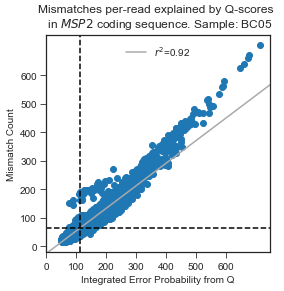

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.plot(mismatch_df["quality"], mismatch_df["empirical"], 'o', label="")
ax.autoscale(False)
ax.plot(xs, predict, color='darkgrey', label="$r^2$=%.02f" % result.rsquared)

ax.axvline(mismatch_df["quality"].mean(), color='black', linestyle='dashed')
ax.axhline(mismatch_df["empirical"].mean(), color='black', linestyle='dashed')

ax.set_title("Mismatches per-read explained by Q-scores \n in $MSP2$ coding sequence. Sample: %s" % sample)
ax.set_xlabel("Integrated Error Probability from Q")
ax.set_ylabel("Mismatch Count")

ax.set_xticks(np.arange(0, 700, 100))
ax.set_yticks(np.arange(0, 700, 100))

ax.legend()

# save
fig.savefig(os.path.join(figs_dir, "%s.%s.q_across_reads.png" % (sample, gene_dt["name"])),
            bbox_inches="tight",
            pad_inches=0.5)